<div style="text-align:center; color:white; background-color:black; padding:10px; border-radius:10px; font-size:30px;">
    <strong>Estimating Depth and Global Atmospheric Light for Image Dehazing Using Type-2 Fuzzy Approach</strong>
</div>

<span style="font-size:18px;"> 
    \( O_{H}(m,n) = O_{1}(m,n) + O_{2}(m,n) \)
    <br>
    \( O_{1}(m,n) = O_{J}(m,n)T(m,n) \)
    <br>
    \( O_{2}(m,n) = L(1 - T(m,n)) \)
    <br>
    \( T(m,n) = e^{- \beta  D(m,n)} \)
</span>


In [2]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [3]:
def get_min_channel(image_np):
    # Extracting R, G, B channels
    R = image_np[:, :, 0]
    G = image_np[:, :, 1]
    B = image_np[:, :, 2]
    min_channel = np.minimum(np.minimum(R, G), B)
    return min_channel

In [4]:
# Step 1: Extract patches
def get_patches(minimum_Channel, patch_size, F_HW):
    padded_min_channel = np.pad(min_channel, pad_width=1, mode='edge')
    rows, cols = min_channel.shape
    patch_dict = {}
    for i in range(rows):
        for j in range(cols):
            # Extract the 3x3 patch centered at (i, j) in the original min_channel
            patch = padded_min_channel[i:i+3, j:j+3]
            patch_dict[(i, j)] = patch
    return patch_dict

In [5]:
# Step 2: Similarity Function Calculation
def similarity_function(omega, H_h, sigma):
    epsilon = 1e-10
    return np.exp(-0.5 * ((omega - H_h) / (sigma+epsilon)) ** 2)

In [6]:
def h_middle_means(patch):
    """
    Calculates the h-middle means for a kxk patch as per the specified formula.
    
    Parameters:
    - patch (np.ndarray): A kxk numpy array representing the pixel values in a patch.
    
    Returns:
    - np.ndarray: An array containing the h-middle means for this patch.
    """
    k = patch.shape[0]
        
    flat_patch = patch.flatten().astype(np.int32)
    num_pixels = k * k
    h_values = int((num_pixels + 1) / 2)  # This is the number of h-middle means
    
    # Center index in a flattened array
    center_index = num_pixels // 2  # Middle pixel index
    center_value = flat_patch[center_index]
    sum = center_value
    l = center_index
    r = center_index;
    h_middle_means_list = []
    for i in range(h_values):
        avg = sum/(2*i+1);
        l-=1
        r+=1
        if(l>=0 and r<num_pixels):
            sum+=(flat_patch[l] + flat_patch[r])
        h_middle_means_list.append(avg)
    return h_middle_means_list
        

In [7]:
def calculate_h_by_k_matrix(patch):
    h_middle_means_list = h_middle_means(patch)
    flat_patch = patch.flatten()
    
    h = len(h_middle_means_list)
    k = len(flat_patch)
    
    # Initialize the h-by-k matrix
    result_matrix = np.zeros((h, k))
    sigma = np.std(h_middle_means_list)
    for i in range(h):
        for j in range(k):
            result_matrix[i, j] = similarity_function(flat_patch[j], h_middle_means_list[i], sigma)
    
    return result_matrix

In [8]:
def get_weights_for_each_patch(patch):
    mat = calculate_h_by_k_matrix(patch)
    return np.mean(mat, axis=0)

In [9]:
def depth_map_estimate_for_each_pixel(patch):
    """
    Calculates the weighted average of a flattened kxk patch using the specified weights.
    
    Parameters:
    - patch (np.ndarray): A kxk numpy array representing the pixel values in a patch.
    - weights (np.ndarray): A 1D array of length k*k representing the weights for each pixel.
    
    Returns:
    - float: The weighted average of the patch.
    """
    flat_patch = patch.flatten()
    weights = get_weights_for_each_patch(patch)
    
    # Calculate the weighted average
    weighted_sum = np.dot(flat_patch, weights)
    weight_sum = np.sum(weights)
    weighted_avg = weighted_sum / weight_sum
    
    return weighted_avg

In [10]:
def scene_transmission_for_each_pixel(patch, bita):
    d = depth_map_estimate_for_each_pixel(patch)
    return np.exp(-bita*d)

In [11]:
def global_atmospheric_light_estimation(patch_dict):
    rows, cols = min_channel.shape
    L_total = 0
    for i in range(rows):
        for j in range(cols):
            mat = calculate_h_by_k_matrix(patch_dict[(i,j)])
            min_value = np.min(mat)
            L_total+=min_value
    L_estimated = L_total/(rows*cols)
    return L_estimated

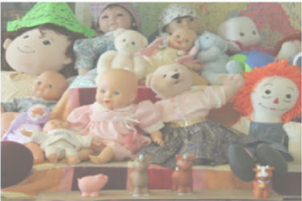

In [14]:
image = Image.open('new.png')
# scale_factor = 0.2
# new_size = (int(image.width * scale_factor), int(image.height * scale_factor))
# print(new_size)
# resized_image = image.resize(new_size)
image_np = np.array(image)

# image_np = np.array([
#     [[255, 0, 0], [0, 255, 0], [0, 0, 255]],         # Row 1: Red, Green, Blue
#     [[255, 255, 0], [0, 255, 255], [255, 0, 255]],   # Row 2: Yellow, Cyan, Magenta
#     [[128, 128, 128], [64, 64, 64], [192, 192, 192]] # Row 3: Gray, Dark Gray, Light Gray
# ], dtype=np.uint8)
# image = Image.fromarray(image_np, 'RGB')
# large_image = image.resize((200, 200), Image.NEAREST)
# large_image
image

In [15]:
k = 3  # Patch size
F_HW = int((math.sqrt(k) - 1) / 2)  # Half-filter width
bita = 1

In [16]:
min_channel = get_min_channel(image_np)
patch_dict = get_patches(min_channel, k, F_HW)
L = global_atmospheric_light_estimation(patch_dict)
L = L*255 # Scaling L

In [17]:
rows, cols = min_channel.shape
enhanced_image_np = np.zeros((rows, cols, 3))
for i in range(rows):
    for j in range(cols):
        T = scene_transmission_for_each_pixel(patch_dict[(i,j)], bita)
        for k in range(3):
            enhanced_image_np[i][j][k] = ((image_np[i][j][k]-L)/T + L)

In [20]:
T

7.307425713157722e-69

In [19]:
enhanced_image = Image.fromarray(enhanced_image_np)

TypeError: Cannot handle this data type: (1, 1, 3), <f8

In [ ]:
enhanced_image